# 決定木とランダムフォレスト（Random Forests）

原作者のJoseさんのブログをまずはご覧ください。
[こちら](https://medium.com/@josemarcialportilla/enchanted-random-forest-b08d418cb411)


Pythonをつかって、決定木とランダムフォレストの世界を探検してみましょう。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

In [3]:
plt.style.use('seaborn-whitegrid')
# sns.set_style('whitegrid')

## ランダムフォレスト分類器

ランダムフォレスト（Random forests）は、アンサンブル学習法の一つです。アンサンブル学習法は、いくつかの分類器を集めて構成されるものですが、ここでは決定木が使われます。（木が集まるから森というわけです）

In [4]:
# 架空のデータを用意します
from sklearn.datasets import make_blobs

In [5]:
X, y = make_blobs(n_samples=500, centers=4, random_state=8, cluster_std=2.4)

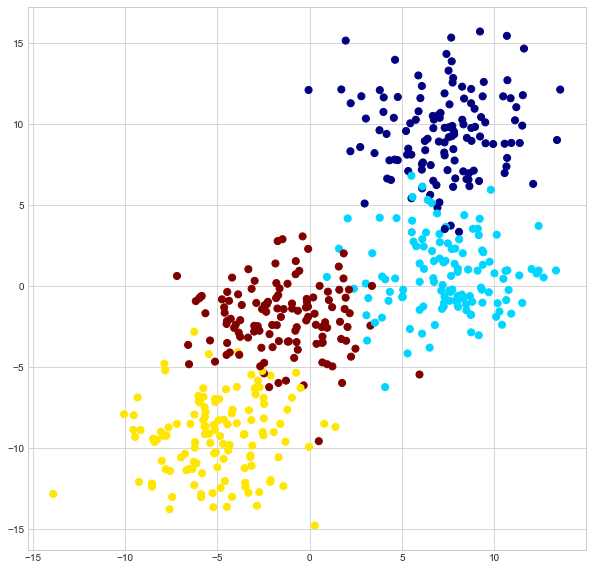

In [6]:
# Scatter plot the points
plt.figure(figsize=(10, 10))
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='jet')

In [7]:
from sklearn.tree import DecisionTreeClassifier

### 描画のための関数

In [20]:
def visualize_tree(classifier, X, y, boundaries= True, xlim=None, ylim=None):
    '''
    決定木の可視化
    INPUTS: 分類モデル, X, y, optional x/y limits.
    OUTPUTS: Meshgridを使った決定木の可視化
    '''
    # fitを使ったモデルの構築
    classifier.fit(X, y)
    
    # 軸を自動調整
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    
    # meshgridをつくります
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    
    # 分類機の予測をZとして保存
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # meshgridを使って整形
    Z = Z.reshape(xx.shape)
    
    # 分類ごとに色を付ける
    plt.figure(figsize=(10, 10))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='jet')
    
    # 訓練データも描画
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    def plot_boundaries(i, xlim, ylim):
        '''
        境界線を描き込み
        '''
        if i < 0:
            return
        
        tree = classifier.tree_
        
        # 境界を描画するために、再帰的に呼出
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim, [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim, [tree.threshold[i], ylim[0]])
    
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

深さ2までのプロットを描いて見ます。

In [21]:
# model
clf = DecisionTreeClassifier(max_depth=2, random_state=0)

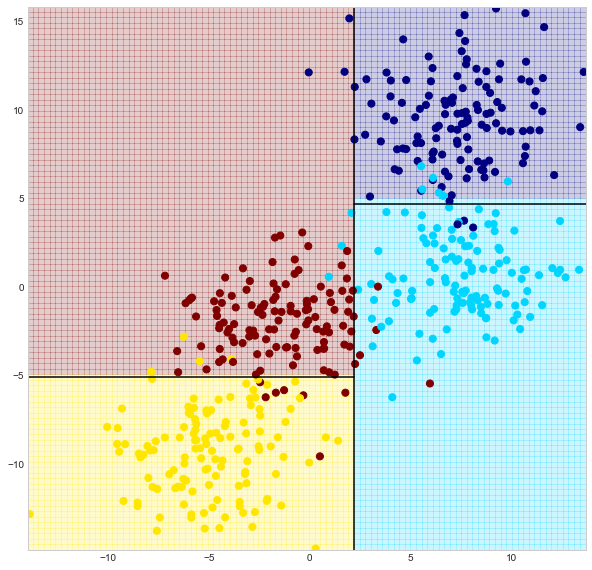

In [22]:
# 描画
visualize_tree(clf, X, y)

深さを4にしてみます

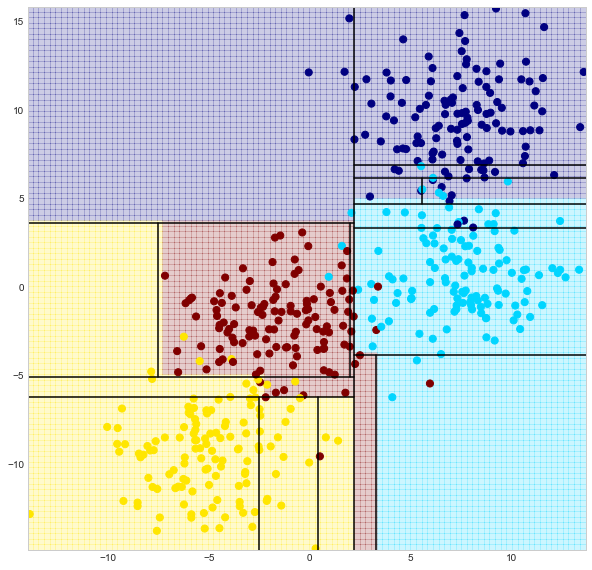

In [23]:
clf = DecisionTreeClassifier(max_depth=4, random_state=0)
visualize_tree(clf, X, y)

あまりにも細かく分類すると、過学習（over fitting）の問題が起こります。

## Random Forests

過学習の問題を回避するための一つの方法が、ランダムフォレストです。

ランダムフォレストは、学習データの一部をランダムに選んで、決定木を作ります。これを繰り返すことによって、色々な種類の木が出来るので、汎化性能が下がるのを避けることが出来るわけです。

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
# n_estimatorsは、作る木の数
clf = RandomForestClassifier(n_estimators=100, random_state=10)

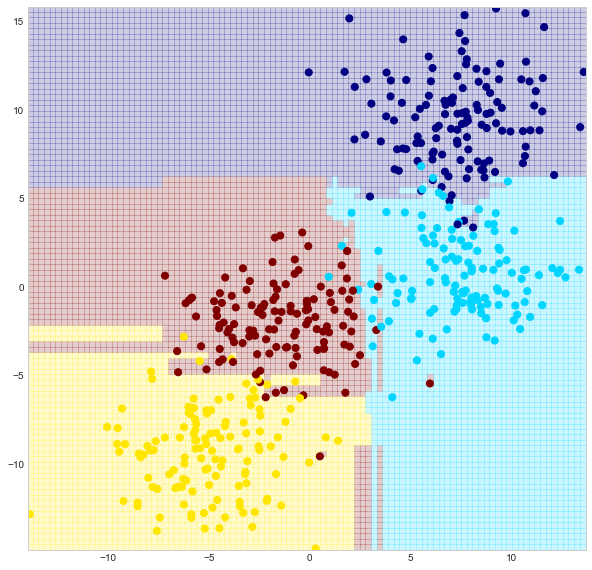

In [27]:
# 境界線を描かない
visualize_tree(clf, X, y, boundaries=False)

決定木とは違った境界線が描かれているのがわかります。

## Random Forest Regression
ランダムフォレストは、分類だけではなく、回帰にも使うことができます。

ダミーのデータを作って、試してみましょう。

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
x = 10 * np.random.rand(100)

In [30]:
def sin_model(x, sigma=0.2):
    '''
    大きな波+小さな波+ノイズからなるダミーデータです
    '''
    
    noise = sigma * np.random.randn(len(x))
    
    return np.sin(5 * x) + np.sin(0.5 * x) + noise

In [31]:
# xからyを計算
y = sin_model(x)

<Container object of 3 artists>

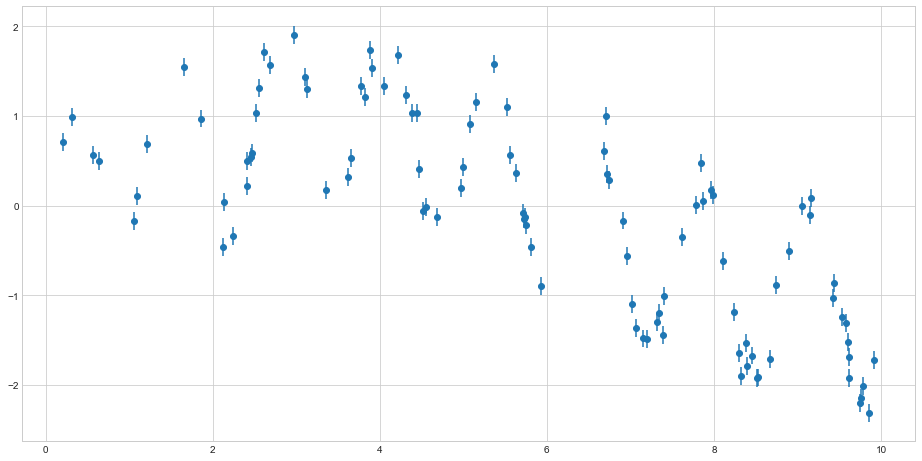

In [32]:
# plot
plt.figure(figsize=(16, 8))
plt.errorbar(x, y, 0.1, fmt='o')

このデータを単純な線形回帰で予測しようとしても難しいのは、一目瞭然です。 そこで、ランダムフォレストを使って見ることにしましょう。

In [48]:
# Xを用意
xfit = np.linspace(0, 10, 1000)

In [54]:
# 回帰モデル
rfl = RandomForestRegressor(100)

In [55]:
# 学習
rfl.fit(x[:, None], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [56]:
# 予測値
yfit = rfl.predict(xfit[:, None])

In [57]:
# 実際の値
ytrue = sin_model(xfit, 0)

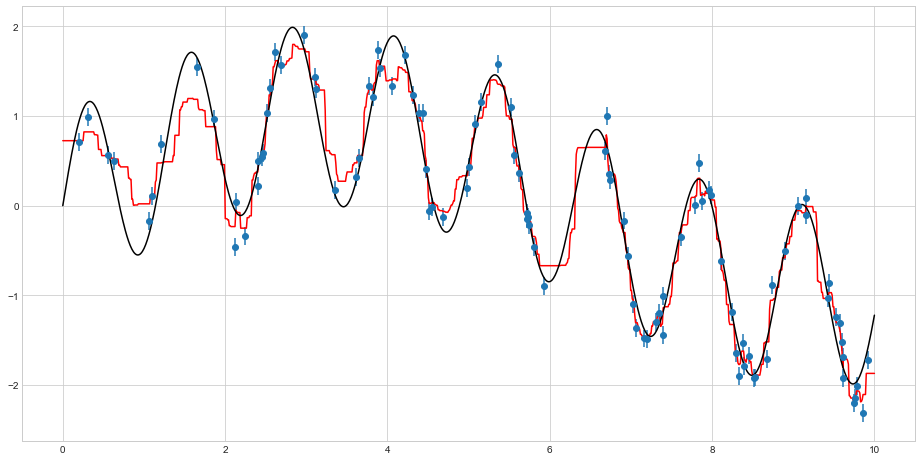

In [58]:
# plot
plt.figure(figsize=(16,8))

plt.errorbar(x, y, 0.1, fmt='o')

plt.plot(xfit, yfit, '-r')
plt.plot(xfit, ytrue, '-k')

ランダムフォレストは、このように分類だけでは無く、回帰にも使えるので、非常に応用範囲が広い方法論です。